lon [-118.82915, -117.27235, -117.14731, -117.2858, -117.41601]
lat [36.48947, 34.2431, 34.05977, 34.41639, 33.99958]
value [4.903946049239494e-05, 1.9052325399115944e-05, 0.0004369223458482, -0.0003834533691389, 2.6532319942873528e-05]
Points data for SCUT - EPA: W126: {'lon': [-118.82915, -117.27235, -117.14731, -117.2858, -117.41601, -118.130511, -116.830074, -119.40262, -118.851825, -117.5898, -116.54101, -119.716433, -119.055018, -116.85841, -116.38893, -119.741332, -117.274063, -117.22764, -119.016787, -119.874739, -117.4924, -119.503659, -117.49201, -118.7777, -119.062613, -118.78863, -121.164457, -117.62914, -116.21537, -117.33098, -117.85036, -97.282099, -119.643447, -121.003373, -105.188587, -96.94459, -117.024804, -119.272606, -97.475083, -97.196284, -105.177989, -120.433671, -105.070358, -76.296946, -118.53276, -95.999247, -105.141122, -96.786419, -120.836008, -120.034203, -97.462931, -121.09959, -111.60972, -119.7062, -84.36625, -116.847778, -95.764537, -115.56306, -97.494

/home/esil/anaconda3/envs/devin_env/lib/python3.9/site-packages/esil/rsm_helper/model_property.py:75: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  self.lats, self.lons = transform(projection, 'EPSG:4326',grid_x, grid_y)
/home/esil/anaconda3/envs/devin_env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/esil/anaconda3/envs/devin_env/lib/python3.9/site-packages/esil/map_helper.py:928: RuntimeWarning: All-NaN slice encountered
  np.nanmin(grid_concentration),
/home/esil/anaconda3/envs/devin_env/lib/python3.9/site-packages/esil/map_helper.py:929: RuntimeWarning: All-NaN slice encountered
  np.nanmax(grid_concentration),
/home/esil/anaconda3/envs/devin_env/lib/python3.9/site-packages/esil/map_helper.py:930: RuntimeWarning: Mean of empty slice
  np.nanmean(grid_concentration),


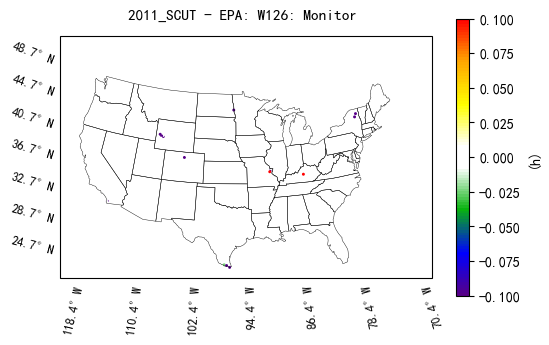

The data fusion plot for SCUT - EPA: W126 is saved to /DeepLearning/mnt/shixiansheng/data_fusion/output/TestMap/SCUT - EPA: W126_Missing daily data.png
Done!


In [28]:
import os
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# for show maps
from esil.rsm_helper.model_property import model_attribute
from esil.map_helper import get_multiple_data, show_maps
import cmaps

cmap_delta = cmaps.ViBlGrWhYeOrRe
cmap_conc = cmaps.WhiteBlueGreenYellowRed

def plot_us_map(
    fusion_output_file,
    model_file,
    grid_column,  # 网格数据指定列
    monitor_column,  # 监测数据指定列
    save_path=None,
    boundary_json_file="/DeepLearning/mnt/Devin/boundary/USA_State.json",
    points_data=None,  # 点数据
    set_zero=True  # 添加参数来控制是否将浓度设置为零
):
    """
    description: plot the US map with different data fusion results
    @param {string} fusion_output_file: the data fusion output file
    @param {string} model_file: the model file used for data fusion
    @param {string} grid_column: 网格数据指定列
    @param {string} monitor_column: 监测数据指定列
    @param {string} save_path: the path to save the plot
    @param {string} boundary_json_file: the boundary file for the US map
    @param {dictionary} points_data: 点数据，包含经纬度和浓度值，default=None
    @param {bool} set_zero: 是否将浓度值设置为0，默认False
    @return None
    """
    # 注意
    mp = model_attribute(model_file)
    proj, longitudes, latitudes = mp.projection, mp.lons, mp.lats
    df_data = pd.read_csv(fusion_output_file)
    if grid_column not in df_data.columns:
        print(f"The data fusion file does not contain the {grid_column} column!")
        return
    layout = None

    # 移除对Period的依赖，不再有周期循环
    dict_data = {}

    # 检查是否存在指定列的数据
    if grid_column not in df_data.columns or df_data[grid_column].empty:
        print(f"No data found in {grid_column}. Skipping.")
        return

    # 将网格浓度全部设为nan
    grid_concentration_model = np.full(longitudes.size, np.nan)
    grid_concentration_model = grid_concentration_model.reshape(longitudes.shape)

    vmax_conc = np.nanpercentile(grid_concentration_model, 99.5)
    vmin_conc = np.nanpercentile(grid_concentration_model, 0.5)
    value_range = [-0.1, 0.1]

    # 提取特定列的点数据
    points_data_period = points_data.get(monitor_column, None)
    if points_data_period:
        # 设定点大小为15,以及指定颜色
        points_data_period['symbol_size'] = [4.5] * len(points_data_period['lon'])
        points_data_period['edgecolor'] = 'None'
        points_data_period['cmaq'] = cmap_conc,
        print(f"Points data for {monitor_column}: {points_data_period}")
        # 添加点数据到dict_data
        get_multiple_data(
            dict_data,
            dataset_name=f"2011_{monitor_column}: Monitor",
            variable_name="",
            grid_x=longitudes,
            grid_y=latitudes,
            grid_concentration=grid_concentration_model,
            points_data=points_data_period  # 传入点数据
        )
    else:
        print(f"No points data found for {monitor_column}")

    fig = show_maps(
        dict_data,
        cmap=cmap_delta,
        unit="h",
        show_lonlat=True,
        projection=proj,
        is_wrf_out_data=True,
        boundary_file=boundary_json_file,
        show_original_grid=True,
        show_grid_line=None,
        panel_layout=layout,
        show_minmax=False,
        delta_map_settings={
            "cmap": cmap_conc,
            "value_range": (-0.1, 0.1),
            "colorbar_ticks_num": None,
            "colorbar_ticks_value_format": ".2f",
            "value_format": ".2f",
        },
        title_fontsize=11,
        xy_title_fontsize=9,
        show_dependenct_colorbar=True,
        value_range=value_range,
    )

    if save_path is not None:
        save_file = os.path.join(save_path, f"{monitor_column}_Missing daily data.png")
        fig.savefig(save_file, dpi=300)
        print(f"The data fusion plot for {monitor_column} is saved to {save_file}")
    dict_data = {}


if __name__ == "__main__":
    save_path = r"/DeepLearning/mnt/shixiansheng/data_fusion/output/TestMap"
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    model_file = r"/backupdata/data_EPA/EQUATES/EQUATES_data/HR2DAY_LST_ACONC_v532_cb6r3_ae7_aq_WR413_MYR_STAGE_2011_12US1_2011.nc"
    data_fusion_file = r"/DeepLearning/mnt/shixiansheng/data_fusion/output/Region/2011_ROWCOLRegion_Tz_CONUS_ST.csv"

    points_data_df = pd.read_csv('/DeepLearning/mnt/shixiansheng/data_fusion/output/W126/2011_MonitorW126_Compare.csv')
    points_data = {}
    monitor_column = 'SCUT - EPA: W126'  # 监测数据指定列
    grid_column = 'gmt_offset'  # 网格数据指定列

    period_data = points_data_df[points_data_df[monitor_column].notna()]

    # 过滤掉极端的经纬度，远离美国陆地外的监测站
    period_data = period_data[(period_data['Lon'] >= -134.4) & (period_data['Lon'] <= -70)]
    points_data[monitor_column] = {'lon': period_data['Lon'].tolist(),
                                   'lat': period_data['Lat'].tolist(),
                                   'value': period_data[monitor_column].tolist()}

    # 打印前五行数据
    for key in points_data[monitor_column]:
        print(key, points_data[monitor_column][key][:5])

    for file in [data_fusion_file]:
        plot_us_map(file, model_file, grid_column, monitor_column, save_path, points_data=points_data, set_zero=True)
    print("Done!")